In [64]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [65]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training CNX with *minimal_SARIMAX*

In [66]:
import sys
sys.path.append('../')

In [67]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [68]:
train_set = pd.read_csv('6Hsampled_data_set/CNX/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/CNX/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/CNX/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [69]:
order = (2, 1, 0)
seasonal_order = (0, 1, 1, 1461)

exog_order = {}
exog_order['Temp'] = (1, 1, 0)
exog_order['WindSpeed'] = (1, 1, 0)
exog_order['WindDirSin'] = (1, 0, 0)
exog_order['WindDirCos'] = (1, 0, 0)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (0, 1, 1, 1461)
exog_seasonal_order['WindSpeed'] = (0, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 0, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [70]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [71]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.9995, lr_decay_iter=0.75,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:33<00:00, 16.05it/s]


ITER#0  RMSE:11.336230498349368


100%|██████████| 4383/4383 [04:26<00:00, 16.42it/s]


ITER#0  RMSE:12.459274959513744


100%|██████████| 4383/4383 [04:23<00:00, 16.65it/s]


ITER#0  RMSE:7.007745092379591


100%|██████████| 4383/4383 [04:26<00:00, 16.42it/s]

ITER#0  RMSE:7.072138921552031


#### Chiangmai

In [ ]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([1e-6, 1e-7, 1e-7, 1e-7, 1e-7]), lr_decay=0.9995, lr_decay_iter=0.75,
                                  step=12, n_iter=1, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

In [20]:
model.params

{'p': array([0.2348413 , 0.18150585]),
 'pX': array([0.00769068, 0.00020668, 0.01244957]),
 'd': array([0.06357296]),
 'q': array([0.]),
 'P': array([0.]),
 'D': array([0.17461349]),
 'Q': array([0.02256248]),
 'c': 0.012678497622182257}

In [ ]:
with open('../model_save/model_cnx.model',"wb") as f:
    pickle.dump(model, f)

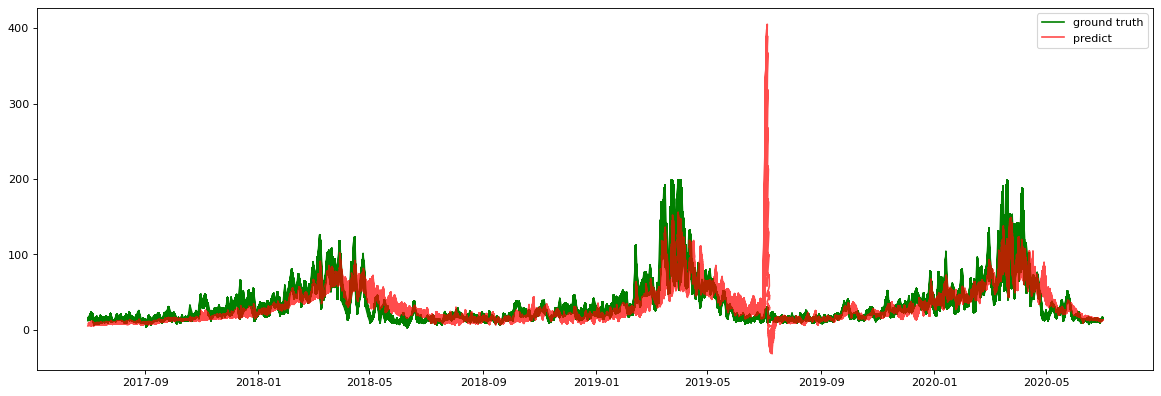

In [21]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [23]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                 step=12, n_iter=1, learn=False, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [07:28<00:00,  6.20it/s]

ITER#0  RMSE:30.999111400974012


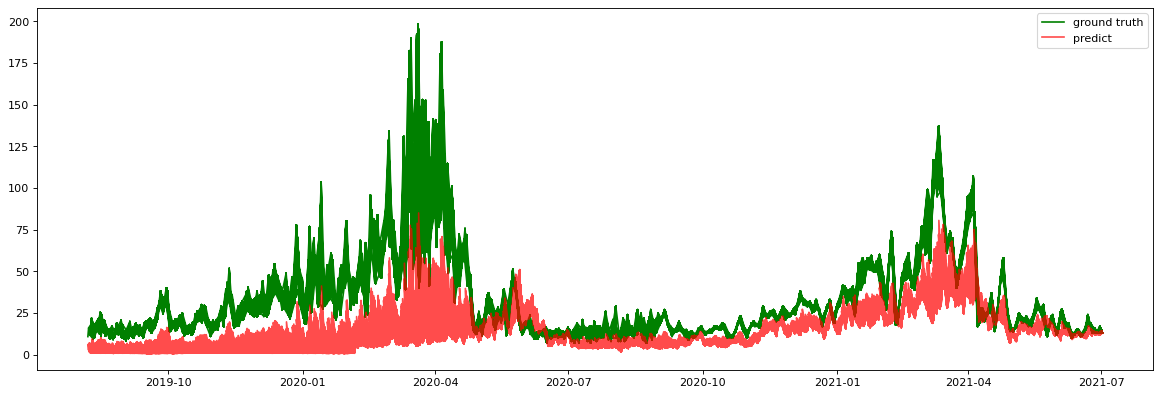

In [24]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [25]:
((Error_save**2).mean())**(1/2)

30.999111400974012

In [ ]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_CNX.csv')